In [1]:
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)



torch:  2.0 ; cuda:  2.0.1
detectron2: 0.6


## Get data

In [5]:

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import torch
from source.data_utils import *

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.evaluation import COCOEvaluator

from detectron2.data import DatasetCatalog, MetadataCatalog


     


## Register the SODA10M dataset

In [3]:
import os
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo


# Register the COCO dataset from the custom path
# Assuming you have "instances_train.json" and "instances_val.json" in the directory
# Update these json file names if yours are different
register_coco_instances("soda10m_train", {}, 
                        "SSLAD-2D/labeled/annotations/instance_train.json", 
                        "SSLAD-2D/labeled/train")
register_coco_instances("soda10m_val", {}, 
                        "SSLAD-2D/labeled/annotations/instance_val.json", 
                        "SSLAD-2D/labeled/val")
register_coco_instances("soda10m_test", {}, 
                        "SSLAD-2D/labeled/annotations/instance_test.json", 
                        "SSLAD-2D/labeled/test")
# Call this function with the path to your original and new subset JSON files
#create_val_subset("SSLAD-2D/labeled/annotations/instance_val.json","SSLAD-2D/labeled/annotations/instance_val_subset.json",1000)
create_val_subset("SSLAD-2D/labeled/annotations/instance_test.json","SSLAD-2D/labeled/annotations/instance_test_subset.json",2500)
#Subset of 1000 images
register_coco_instances("soda10m_val_subset", {}, 
                        "SSLAD-2D/labeled/annotations/instance_val_subset.json", 
                        "SSLAD-2D/labeled/val")

register_coco_instances("soda10m_test_subset", {}, 
                        "SSLAD-2D/labeled/annotations/instance_test_subset.json", 
                        "SSLAD-2D/labeled/test")

[11/30 10:47:01 d2.data.datasets.coco]: Loaded 5000 images in COCO format from SSLAD-2D/labeled/annotations/instance_val.json


namespace(name='soda10m_val_limited',
          thing_classes=['Pedestrian',
                         'Cyclist',
                         'Car',
                         'Truck',
                         'Tram',
                         'Tricycle'],
          thing_dataset_id_to_contiguous_id={1: 0,
                                             2: 1,
                                             3: 2,
                                             4: 3,
                                             5: 4,
                                             6: 5})

## Training

In [8]:

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
    
    @classmethod
    def get_evaluator(cls, cfg, dataset_name, output_folder=None):
        # This method returns the evaluator instance
        return cls.build_evaluator(cfg, dataset_name, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks
    

In [9]:
from detectron2.data.samplers import RandomSubsetTrainingSampler
from detectron2.data import build_detection_test_loader   # the default mapper
from detectron2.evaluation import inference_on_dataset




cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))


cfg.MODEL.DEVICE = "cuda"
# Update the dataset names to the registered names
cfg.DATASETS.TRAIN = ("soda10m_train",)
cfg.DATASETS.TEST = ("soda10m_val_subset",)  # or an empty tuple if you don't have a validation set


cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
#cfg.MODEL.WEIGHTS = r"C:\Users\melmourabitagharbi\detectron2\detectron2\checkpoint\faster_rcnn_R_101_FPN_3x\model_final_f6e8b1.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []  # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Number of classes in SODA10m

cfg.TEST.EVAL_PERIOD = 100


num_gpu = 1
bs = (num_gpu * 2)
cfg.SOLVER.BASE_LR = 0.02 * bs / 16  # pick a good LR
#cfg.SOLVER.BASE_LR = 0.01  # pick a good LR

# Before starting your training or inference
torch.cuda.empty_cache()
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:50'

# Setup the output directory
cfg.OUTPUT_DIR = r"SSLAD-2D/labeled/output/save"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Create the trainer and start training
#trainer = DefaultTrainer(cfg) #Training without evaluation.
trainer = MyTrainer(cfg) #Training with evaluation
trainer.resume_or_load(resume=False)
trainer.train()




[11/30 10:49:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/30 10:49:29 d2.data.datasets.coco]: Loaded 5000 images in COCO format from SSLAD-2D/labeled/annotations/instance_train.json
[11/30 10:49:29 d2.data.build]: Removed 33 images with no usable annotations. 4967 images left.
[11/30 10:49:29 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
| Pedestrian | 4901         |  Cyclist   | 6548         |    Car     | 23456        |
|   Truck    | 4297         |    Tram    | 1681         |  Tricycle  | 227          |
|            |              |            |              |            |              |
|   total    | 41110        |            |              |            |              |
[11/30 10:49:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, samp

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (7, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (7,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (24, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (24,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[11/30 10:49:30 d2.engine.train_loop]: Starting training from iteration 0


C:\Users\melmourabitagharbi\.conda\envs\p38_env\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/30 10:49:47 d2.utils.events]:  eta: 0:10:28  iter: 19  total_loss: 2.486  loss_cls: 1.93  loss_box_reg: 0.5242  loss_rpn_cls: 0.03106  loss_rpn_loc: 0.05796    time: 0.6664  last_time: 0.6715  data_time: 0.0976  last_data_time: 0.0009   lr: 4.9952e-05  max_mem: 2586M
[11/30 10:50:12 d2.utils.events]:  eta: 0:11:15  iter: 39  total_loss: 1.724  loss_cls: 1.044  loss_box_reg: 0.5497  loss_rpn_cls: 0.03532  loss_rpn_loc: 0.07961    time: 0.8308  last_time: 0.6776  data_time: 0.0011  last_data_time: 0.0009   lr: 9.9902e-05  max_mem: 2607M
[11/30 10:50:27 d2.utils.events]:  eta: 0:11:13  iter: 59  total_loss: 1.345  loss_cls: 0.6012  loss_box_reg: 0.617  loss_rpn_cls: 0.03407  loss_rpn_loc: 0.06404    time: 0.8053  last_time: 0.7119  data_time: 0.0012  last_data_time: 0.0012   lr: 0.00014985  max_mem: 2607M
[11/30 10:50:43 d2.utils.events]:  eta: 0:11:31  iter: 79  total_loss: 1.366  loss_cls: 0.542  loss_box_reg: 0.5904  loss_rpn_cls: 0.03432  loss_rpn_loc: 0.08925    time: 0.7978  las

[11/30 10:52:45 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP    | category   | AP    | category   | AP     |
|:-----------|:------|:-----------|:------|:-----------|:-------|
| Pedestrian | 5.994 | Cyclist    | 5.413 | Car        | 17.493 |
| Truck      | 1.148 | Tram       | 0.323 | Tricycle   | 0.000  |
[11/30 10:52:45 d2.engine.defaults]: Evaluation results for soda10m_val_subset in csv format:
[11/30 10:52:45 d2.evaluation.testing]: copypaste: Task: bbox
[11/30 10:52:45 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/30 10:52:45 d2.evaluation.testing]: copypaste: 5.0620,12.9202,2.1840,2.4712,4.8348,9.8955
Loss on Validation done 101/1000. 0.0000 s / img. ETA=0:01:34
Loss on Validation done 201/1000. 0.0000 s / img. ETA=0:01:24
Loss on Validation done 301/1000. 0.0000 s / img. ETA=0:01:14
Loss on Validation done 401/1000. 0.0001 s / img. ETA=0:01:03
Loss on Validation done 501/1000. 0.0000 s / img. ETA=0:00:52
Loss on Validation done 601/1

[11/30 10:57:40 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.30 seconds.
[11/30 10:57:40 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[11/30 10:57:40 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.09 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.090
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.267
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.124
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.287
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.316
 Aver

[11/30 11:02:24 d2.evaluation.evaluator]: Inference done 806/1000. Dataloading: 0.0006 s/iter. Inference: 0.1009 s/iter. Eval: 0.0003 s/iter. Total: 0.1018 s/iter. ETA=0:00:19
[11/30 11:02:29 d2.evaluation.evaluator]: Inference done 854/1000. Dataloading: 0.0006 s/iter. Inference: 0.1010 s/iter. Eval: 0.0003 s/iter. Total: 0.1019 s/iter. ETA=0:00:14
[11/30 11:02:34 d2.evaluation.evaluator]: Inference done 902/1000. Dataloading: 0.0006 s/iter. Inference: 0.1012 s/iter. Eval: 0.0003 s/iter. Total: 0.1021 s/iter. ETA=0:00:10
[11/30 11:02:39 d2.evaluation.evaluator]: Inference done 951/1000. Dataloading: 0.0006 s/iter. Inference: 0.1012 s/iter. Eval: 0.0003 s/iter. Total: 0.1021 s/iter. ETA=0:00:05
[11/30 11:02:44 d2.evaluation.evaluator]: Inference done 1000/1000. Dataloading: 0.0006 s/iter. Inference: 0.1012 s/iter. Eval: 0.0003 s/iter. Total: 0.1021 s/iter. ETA=0:00:00
[11/30 11:02:44 d2.evaluation.evaluator]: Total inference time: 0:01:41.874585 (0.102387 s / iter per device, on 1 devi

[11/30 11:06:36 d2.evaluation.evaluator]: Inference done 353/1000. Dataloading: 0.0006 s/iter. Inference: 0.1022 s/iter. Eval: 0.0006 s/iter. Total: 0.1034 s/iter. ETA=0:01:06
[11/30 11:06:41 d2.evaluation.evaluator]: Inference done 402/1000. Dataloading: 0.0006 s/iter. Inference: 0.1022 s/iter. Eval: 0.0005 s/iter. Total: 0.1034 s/iter. ETA=0:01:01
[11/30 11:06:46 d2.evaluation.evaluator]: Inference done 451/1000. Dataloading: 0.0006 s/iter. Inference: 0.1021 s/iter. Eval: 0.0005 s/iter. Total: 0.1033 s/iter. ETA=0:00:56
[11/30 11:06:51 d2.evaluation.evaluator]: Inference done 500/1000. Dataloading: 0.0006 s/iter. Inference: 0.1021 s/iter. Eval: 0.0005 s/iter. Total: 0.1033 s/iter. ETA=0:00:51
[11/30 11:06:56 d2.evaluation.evaluator]: Inference done 549/1000. Dataloading: 0.0006 s/iter. Inference: 0.1021 s/iter. Eval: 0.0005 s/iter. Total: 0.1032 s/iter. ETA=0:00:46
[11/30 11:07:01 d2.evaluation.evaluator]: Inference done 598/1000. Dataloading: 0.0006 s/iter. Inference: 0.1021 s/iter.

[11/30 11:10:50 d2.data.common]: Serialized dataset takes 0.43 MiB
WARNING [11/30 11:10:50 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/30 11:10:50 d2.evaluation.evaluator]: Start inference on 1000 batches
[11/30 11:10:53 d2.evaluation.evaluator]: Inference done 11/1000. Dataloading: 0.0005 s/iter. Inference: 0.1022 s/iter. Eval: 0.0003 s/iter. Total: 0.1030 s/iter. ETA=0:01:41
[11/30 11:10:58 d2.evaluation.evaluator]: Inference done 60/1000. Dataloading: 0.0006 s/iter. Inference: 0.1014 s/iter. Eval: 0.0002 s/iter. Total: 0.1023 s/iter. ETA=0:01:36
[11/30 11:11:03 d2.evaluation.evaluator]: Inference done 109/1000. Dataloading: 0.0006 s/iter. Inference: 0.1016 s/iter. Eval: 0.0002 s/iter. Total: 0.1025 s/iter. ETA=0:01:31
[11/30 11:11:08 d2.evaluation.evaluator]: Inference done 158/1000. Dataloading: 0.0006 s/iter. Inference: 0.1015 s/iter. Eval: 0.0002 s/iter. Total: 0.1024 s/iter.

[11/30 11:14:55 d2.utils.events]:  eta: 0:05:50  iter: 539  total_loss: 0.7024  loss_cls: 0.2447  loss_box_reg: 0.3466  loss_rpn_cls: 0.01808  loss_rpn_loc: 0.04286  validation_loss: 0.7095    time: 0.8250  last_time: 0.6463  data_time: 0.0013  last_data_time: 0.0012   lr: 0.0013487  max_mem: 2607M
[11/30 11:15:12 d2.utils.events]:  eta: 0:05:34  iter: 559  total_loss: 0.6564  loss_cls: 0.246  loss_box_reg: 0.317  loss_rpn_cls: 0.01664  loss_rpn_loc: 0.05681  validation_loss: 0.7095    time: 0.8259  last_time: 0.7586  data_time: 0.0013  last_data_time: 0.0020   lr: 0.0013986  max_mem: 2607M
[11/30 11:15:27 d2.utils.events]:  eta: 0:05:19  iter: 579  total_loss: 0.6539  loss_cls: 0.2592  loss_box_reg: 0.3524  loss_rpn_cls: 0.01578  loss_rpn_loc: 0.0479  validation_loss: 0.7095    time: 0.8235  last_time: 0.6650  data_time: 0.0013  last_data_time: 0.0011   lr: 0.0014486  max_mem: 2607M
[11/30 11:15:42 d2.data.datasets.coco]: Loaded 1000 images in COCO format from SSLAD-2D/labeled/annotat

[11/30 11:17:28 d2.engine.defaults]: Evaluation results for soda10m_val_subset in csv format:
[11/30 11:17:28 d2.evaluation.testing]: copypaste: Task: bbox
[11/30 11:17:28 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[11/30 11:17:28 d2.evaluation.testing]: copypaste: 26.5830,48.0599,27.0415,13.1055,22.2708,37.4115
Loss on Validation done 101/1000. 0.0000 s / img. ETA=0:01:35
Loss on Validation done 201/1000. 0.0001 s / img. ETA=0:01:23
Loss on Validation done 301/1000. 0.0001 s / img. ETA=0:01:12
Loss on Validation done 401/1000. 0.0001 s / img. ETA=0:01:02
Loss on Validation done 501/1000. 0.0001 s / img. ETA=0:00:52
Loss on Validation done 601/1000. 0.0001 s / img. ETA=0:00:41
Loss on Validation done 701/1000. 0.0001 s / img. ETA=0:00:31
Loss on Validation done 801/1000. 0.0001 s / img. ETA=0:00:20
Loss on Validation done 901/1000. 0.0001 s / img. ETA=0:00:10
[11/30 11:19:14 d2.utils.events]:  eta: 0:05:04  iter: 599  total_loss: 0.7308  loss_cls: 0.2628  loss_box_reg:

[11/30 11:22:16 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.08 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.290
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.130
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.411
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.181
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.396
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.267
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.391
 Average Recall     (A

[11/30 11:26:50 d2.evaluation.evaluator]: Inference done 845/1000. Dataloading: 0.0006 s/iter. Inference: 0.1018 s/iter. Eval: 0.0002 s/iter. Total: 0.1028 s/iter. ETA=0:00:15
[11/30 11:26:55 d2.evaluation.evaluator]: Inference done 894/1000. Dataloading: 0.0006 s/iter. Inference: 0.1018 s/iter. Eval: 0.0002 s/iter. Total: 0.1028 s/iter. ETA=0:00:10
[11/30 11:27:01 d2.evaluation.evaluator]: Inference done 944/1000. Dataloading: 0.0006 s/iter. Inference: 0.1018 s/iter. Eval: 0.0002 s/iter. Total: 0.1027 s/iter. ETA=0:00:05
[11/30 11:27:06 d2.evaluation.evaluator]: Inference done 993/1000. Dataloading: 0.0006 s/iter. Inference: 0.1018 s/iter. Eval: 0.0002 s/iter. Total: 0.1027 s/iter. ETA=0:00:00
[11/30 11:27:06 d2.evaluation.evaluator]: Total inference time: 0:01:42.375585 (0.102890 s / iter per device, on 1 devices)
[11/30 11:27:06 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:41 (0.101754 s / iter per device, on 1 devices)
[11/30 11:27:07 d2.evaluation.coco_evaluat

[11/30 11:30:56 d2.evaluation.evaluator]: Inference done 409/1000. Dataloading: 0.0006 s/iter. Inference: 0.1009 s/iter. Eval: 0.0002 s/iter. Total: 0.1019 s/iter. ETA=0:01:00
[11/30 11:31:02 d2.evaluation.evaluator]: Inference done 459/1000. Dataloading: 0.0006 s/iter. Inference: 0.1009 s/iter. Eval: 0.0003 s/iter. Total: 0.1019 s/iter. ETA=0:00:55
[11/30 11:31:07 d2.evaluation.evaluator]: Inference done 509/1000. Dataloading: 0.0006 s/iter. Inference: 0.1009 s/iter. Eval: 0.0003 s/iter. Total: 0.1018 s/iter. ETA=0:00:50
[11/30 11:31:12 d2.evaluation.evaluator]: Inference done 559/1000. Dataloading: 0.0006 s/iter. Inference: 0.1009 s/iter. Eval: 0.0003 s/iter. Total: 0.1018 s/iter. ETA=0:00:44
[11/30 11:31:17 d2.evaluation.evaluator]: Inference done 609/1000. Dataloading: 0.0006 s/iter. Inference: 0.1009 s/iter. Eval: 0.0003 s/iter. Total: 0.1018 s/iter. ETA=0:00:39
[11/30 11:31:22 d2.evaluation.evaluator]: Inference done 659/1000. Dataloading: 0.0006 s/iter. Inference: 0.1009 s/iter.

[11/30 11:36:49 d2.engine.hooks]: Overall training speed: 998 iterations in 0:13:21 (0.8031 s / it)
[11/30 11:36:49 d2.engine.hooks]: Total training time: 0:47:13 (0:33:51 on hooks)
[11/30 11:36:49 d2.data.datasets.coco]: Loaded 1000 images in COCO format from SSLAD-2D/labeled/annotations/instance_val_subset.json
[11/30 11:36:49 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/30 11:36:49 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/30 11:36:49 d2.data.common]: Serializing 1000 elements to byte tensors and concatenating them all ...
[11/30 11:36:49 d2.data.common]: Serialized dataset takes 0.43 MiB
WARNING [11/30 11:36:49 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/30 11:36:49 d2.evaluation.evaluator]: Sta

## Plot of the metrics

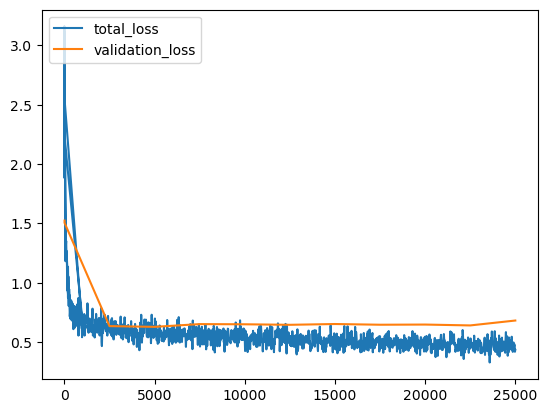

In [24]:
import json
import matplotlib.pyplot as plt

experiment_folder = 'SSLAD-2D/labeled/output/save12epochs'

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

experiment_metrics = load_json_arr(experiment_folder + '/metrics.json')

# Filter data points to include only those that have 'total_loss'
filtered_metrics = [x for x in experiment_metrics if 'total_loss' in x]

plt.plot(
    [x['iteration'] for x in filtered_metrics], 
    [x['total_loss'] for x in filtered_metrics])

# For validation_loss, already doing a filtering
plt.plot(
    [x['iteration'] for x in experiment_metrics if 'validation_loss' in x], 
    [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x])

plt.legend(['total_loss', 'validation_loss'], loc='upper left')
plt.show()


## Evaluation val

In [30]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer

# Set up the configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("soda10m_train",)
cfg.DATASETS.TEST = ("soda10m_val_subset",)  # Provide the tuple even if no validation set is available
cfg.MODEL.WEIGHTS = r"SSLAD-2D/labeled/output/save/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a testing threshold
cfg.TEST.DETECTIONS_PER_IMAGE = 100  # Adjust as necessary
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Set the number of classes

# Build the test loader
test_loader = build_detection_test_loader(cfg, "soda10m_val_subset")

# Create a COCOEvaluator instance
evaluator = COCOEvaluator("soda10m_val_subset", cfg, False, output_dir=r"SSLAD-2D\labeled\output\save")

# Initialize the trainer
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

# Perform the evaluation
eval_results = inference_on_dataset(trainer.model, test_loader, evaluator)
print(eval_results)

[11/30 14:45:53 d2.data.datasets.coco]: Loaded 1000 images in COCO format from SSLAD-2D/labeled/annotations/instance_val_subset.json
[11/30 14:45:53 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/30 14:45:53 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/30 14:45:53 d2.data.common]: Serializing 1000 elements to byte tensors and concatenating them all ...
[11/30 14:45:53 d2.data.common]: Serialized dataset takes 0.43 MiB
WARNING [11/30 14:45:53 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/30 14:45:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

[11/30 14:45:54 d2.data.datasets.coco]: Loaded 5000 images in COCO format from SSLAD-2D/labeled/annotations/instance_train.json
[11/30 14:45:54 d2.data.build]: Removed 33 images with no usable annotations. 4967 images left.
[11/30 14:45:54 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/30 14:45:54 d2.data.build]: Using training sampler TrainingSampler
[11/30 14:45:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/30 14:45:54 d2.data.common]: Serializing 4967 elements to byte tensors and concatenating them all ...
[11/30 14:45:54 d2.data.common]: Serialized dataset takes 2.28 MiB
[11/30 14:45:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from SSLAD-2D/labeled/output/save/model_final.pth ...
[11/30 14:45:55 d2.evaluation.evaluator]: Start inference on 10

## Evaluation Test

In [32]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer

# Set up the configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("soda10m_train",)
cfg.DATASETS.TEST = ("soda10m_test",)  # Provide the tuple even if no validation set is available
cfg.MODEL.WEIGHTS = r"SSLAD-2D/labeled/output/save12epochs/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Set a testing threshold
cfg.TEST.DETECTIONS_PER_IMAGE = 100  # Adjust as necessary
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Set the number of classes

# Build the test loader
test_loader = build_detection_test_loader(cfg, "soda10m_test")

# Create a COCOEvaluator instance
evaluator = COCOEvaluator("soda10m_test", cfg, False, output_dir=r"SSLAD-2D\labeled\output\save\inferenceTest")

# Initialize the trainer
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

# Perform the evaluation
eval_results = inference_on_dataset(trainer.model, test_loader, evaluator)
print(eval_results)

[11/30 14:54:43 d2.data.datasets.coco]: Loaded 10000 images in COCO format from SSLAD-2D/labeled/annotations/instance_test.json
[11/30 14:54:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/30 14:54:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/30 14:54:43 d2.data.common]: Serializing 10000 elements to byte tensors and concatenating them all ...
[11/30 14:54:43 d2.data.common]: Serialized dataset takes 1.25 MiB
WARNING [11/30 14:54:43 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/30 14:54:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=

[11/30 14:54:44 d2.data.datasets.coco]: Loaded 5000 images in COCO format from SSLAD-2D/labeled/annotations/instance_train.json
[11/30 14:54:44 d2.data.build]: Removed 33 images with no usable annotations. 4967 images left.
[11/30 14:54:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/30 14:54:44 d2.data.build]: Using training sampler TrainingSampler
[11/30 14:54:44 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[11/30 14:54:44 d2.data.common]: Serializing 4967 elements to byte tensors and concatenating them all ...
[11/30 14:54:44 d2.data.common]: Serialized dataset takes 2.28 MiB
[11/30 14:54:44 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from SSLAD-2D/labeled/output/save12epochs/model_final.pth ...
[11/30 14:54:45 d2.evaluation.evaluator]: Start inferen

[11/30 14:58:05 d2.evaluation.evaluator]: Inference done 1911/10000. Dataloading: 0.0006 s/iter. Inference: 0.1024 s/iter. Eval: 0.0002 s/iter. Total: 0.1033 s/iter. ETA=0:13:55
[11/30 14:58:10 d2.evaluation.evaluator]: Inference done 1960/10000. Dataloading: 0.0006 s/iter. Inference: 0.1024 s/iter. Eval: 0.0002 s/iter. Total: 0.1033 s/iter. ETA=0:13:50
[11/30 14:58:15 d2.evaluation.evaluator]: Inference done 2009/10000. Dataloading: 0.0006 s/iter. Inference: 0.1024 s/iter. Eval: 0.0002 s/iter. Total: 0.1033 s/iter. ETA=0:13:45
[11/30 14:58:20 d2.evaluation.evaluator]: Inference done 2058/10000. Dataloading: 0.0006 s/iter. Inference: 0.1024 s/iter. Eval: 0.0002 s/iter. Total: 0.1032 s/iter. ETA=0:13:39
[11/30 14:58:25 d2.evaluation.evaluator]: Inference done 2107/10000. Dataloading: 0.0006 s/iter. Inference: 0.1023 s/iter. Eval: 0.0002 s/iter. Total: 0.1032 s/iter. ETA=0:13:34
[11/30 14:58:30 d2.evaluation.evaluator]: Inference done 2156/10000. Dataloading: 0.0006 s/iter. Inference: 0.

[11/30 15:01:47 d2.evaluation.evaluator]: Inference done 4053/10000. Dataloading: 0.0006 s/iter. Inference: 0.1026 s/iter. Eval: 0.0002 s/iter. Total: 0.1035 s/iter. ETA=0:10:15
[11/30 15:01:52 d2.evaluation.evaluator]: Inference done 4101/10000. Dataloading: 0.0006 s/iter. Inference: 0.1026 s/iter. Eval: 0.0002 s/iter. Total: 0.1035 s/iter. ETA=0:10:10
[11/30 15:01:57 d2.evaluation.evaluator]: Inference done 4150/10000. Dataloading: 0.0006 s/iter. Inference: 0.1026 s/iter. Eval: 0.0002 s/iter. Total: 0.1035 s/iter. ETA=0:10:05
[11/30 15:02:02 d2.evaluation.evaluator]: Inference done 4199/10000. Dataloading: 0.0006 s/iter. Inference: 0.1026 s/iter. Eval: 0.0002 s/iter. Total: 0.1035 s/iter. ETA=0:10:00
[11/30 15:02:07 d2.evaluation.evaluator]: Inference done 4248/10000. Dataloading: 0.0006 s/iter. Inference: 0.1026 s/iter. Eval: 0.0002 s/iter. Total: 0.1035 s/iter. ETA=0:09:55
[11/30 15:02:12 d2.evaluation.evaluator]: Inference done 4297/10000. Dataloading: 0.0006 s/iter. Inference: 0.

[11/30 15:05:29 d2.evaluation.evaluator]: Inference done 6205/10000. Dataloading: 0.0006 s/iter. Inference: 0.1024 s/iter. Eval: 0.0002 s/iter. Total: 0.1034 s/iter. ETA=0:06:32
[11/30 15:05:34 d2.evaluation.evaluator]: Inference done 6254/10000. Dataloading: 0.0006 s/iter. Inference: 0.1024 s/iter. Eval: 0.0002 s/iter. Total: 0.1033 s/iter. ETA=0:06:27
[11/30 15:05:39 d2.evaluation.evaluator]: Inference done 6303/10000. Dataloading: 0.0006 s/iter. Inference: 0.1024 s/iter. Eval: 0.0002 s/iter. Total: 0.1033 s/iter. ETA=0:06:22
[11/30 15:05:44 d2.evaluation.evaluator]: Inference done 6353/10000. Dataloading: 0.0006 s/iter. Inference: 0.1024 s/iter. Eval: 0.0002 s/iter. Total: 0.1033 s/iter. ETA=0:06:16
[11/30 15:05:49 d2.evaluation.evaluator]: Inference done 6402/10000. Dataloading: 0.0006 s/iter. Inference: 0.1024 s/iter. Eval: 0.0002 s/iter. Total: 0.1033 s/iter. ETA=0:06:11
[11/30 15:05:54 d2.evaluation.evaluator]: Inference done 6451/10000. Dataloading: 0.0006 s/iter. Inference: 0.

[11/30 15:09:11 d2.evaluation.evaluator]: Inference done 8314/10000. Dataloading: 0.0006 s/iter. Inference: 0.1029 s/iter. Eval: 0.0002 s/iter. Total: 0.1039 s/iter. ETA=0:02:55
[11/30 15:09:16 d2.evaluation.evaluator]: Inference done 8362/10000. Dataloading: 0.0006 s/iter. Inference: 0.1029 s/iter. Eval: 0.0002 s/iter. Total: 0.1039 s/iter. ETA=0:02:50
[11/30 15:09:21 d2.evaluation.evaluator]: Inference done 8408/10000. Dataloading: 0.0006 s/iter. Inference: 0.1030 s/iter. Eval: 0.0002 s/iter. Total: 0.1039 s/iter. ETA=0:02:45
[11/30 15:09:26 d2.evaluation.evaluator]: Inference done 8454/10000. Dataloading: 0.0006 s/iter. Inference: 0.1030 s/iter. Eval: 0.0002 s/iter. Total: 0.1039 s/iter. ETA=0:02:40
[11/30 15:09:31 d2.evaluation.evaluator]: Inference done 8500/10000. Dataloading: 0.0006 s/iter. Inference: 0.1030 s/iter. Eval: 0.0002 s/iter. Total: 0.1040 s/iter. ETA=0:02:35
[11/30 15:09:36 d2.evaluation.evaluator]: Inference done 8546/10000. Dataloading: 0.0006 s/iter. Inference: 0.

[11/30 15:12:09 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[11/30 15:12:09 d2.evaluation.coco_evaluation]: Per-category bbox AP: 
| category   | AP   | category   | AP   | category   | AP   |
|:-----------|:-----|:-----------|:-----|:-----------|:-----|
| Pedestrian | nan  | Cyclist    | nan  | Car        | nan  |
| Truck      | nan  | Tram       | nan  | Tricycle   | nan  |
OrderedDict([('bbox', {'AP': nan, 'AP50': nan, 'AP75': nan, 'APs': nan, 'APm': nan, 'APl': nan, 'AP-Pedestrian': nan, 'AP-Cyclist': nan, 'AP-Car': nan, 'AP-Truck': nan, 'AP-Tram': nan, 'AP-Tricycle': nan})])


## Prediction

In [25]:
from detectron2.data import DatasetCatalog, MetadataCatalog

# Load the validation dataset
dataset_dicts = DatasetCatalog.get("soda10m_val")
metadata = MetadataCatalog.get("soda10m_val")

# Assuming you want to visualize the ground truth for the first image in the dataset
img_dict = dataset_dicts[0]  # or any other index

# Load the image
image = cv2.imread(img_dict["file_name"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Draw ground truth annotations on the image
v_gt = Visualizer(image, metadata, scale=1.2)
out_gt = v_gt.draw_dataset_dict(img_dict)
im_gt = out_gt.get_image()

# Now `im_gt` contains the image with ground truth annotations


[11/30 14:43:55 d2.data.datasets.coco]: Loaded 5000 images in COCO format from SSLAD-2D/labeled/annotations/instance_val.json


In [26]:
# Configuration and model loading for Faster R-CNN
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = r"SSLAD-2D\labeled\output\save250k\model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Set this to the number of classes you have, same as during training


# Create predictor
predictor = DefaultPredictor(cfg)

# Make prediction
outputs = predictor(image)

# We use Visualizer to draw the predictions on the image.
v = Visualizer(image[:, :, ::-1], metadata, scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))


# OpenCV uses BGR color format, and matplotlib uses RGB.
# So, we need to convert the image from BGR to RGB format.
im_pred = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)


[11/30 14:43:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from SSLAD-2D\labeled\output\save250k\model_final.pth ...


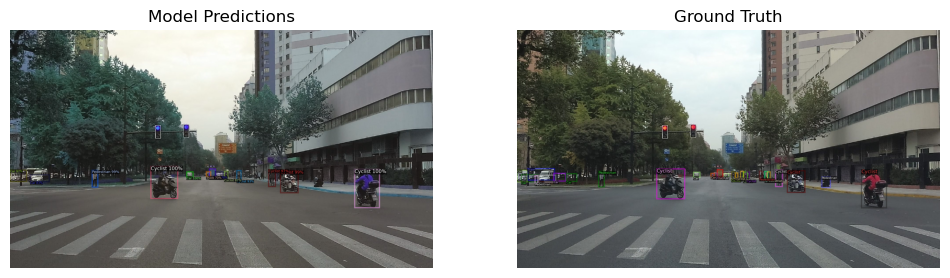

In [27]:
# Display predictions and ground truth side by side using matplotlib
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(im_pred)
plt.title('Model Predictions')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im_gt)
plt.title('Ground Truth')
plt.axis('off')

# Save the figure to a file
plt.savefig("comparison_plot.png", bbox_inches='tight', dpi=300)
# Optionally, you can still display the plot if you want
plt.show()